In [1]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from brain_block.random_initialize import connect_for_block, connect_for_multi_sparse_block
from brain_block.block import block
from analysis.spike_statistics import *
from scipy.ndimage import gaussian_filter1d
from scipy.io import loadmat
%matplotlib inline

# Run simulation

In [ ]:
prob = torch.tensor([[1.]])
path = "small_block_d300"
tau_ui = (8, 40, 10, 50)

ampa_contribution = np.linspace(0., 1., num=100, endpoint=True)
gabaA_contribution = np.linspace(0., 1., num=100, endpoint=True)
contribution = np.stack(np.meshgrid(ampa_contribution, gabaA_contribution, indexing='ij'), axis=-1).reshape(
    (-1, 2))
ampa_contribution = contribution[:, 0]
gabaA_contribution = contribution[:, 1]
ampa = ampa_contribution / 102
nmda = (1 - ampa_contribution) / 500
gabaA = gabaA_contribution / 6
gabaB = (1 - gabaA_contribution) / 108
para = np.stack([ampa, nmda, gabaA, gabaB], axis=1)
para = para.astype(np.float32)
specifcied_gui = para[50 * 100 + 50]

# if os.path.exists(os.path.join(path, 'single', 'block_0.npz')):
#     print("remove")
#     os.remove(os.path.join(path, 'single', 'block_0.npz'))
# connect_for_multi_sparse_block(prob, {'g_Li': 0.03,
#                                       'g_ui': specifcied_gui,
#                                       "V_reset": -65,
#                                         'tao_ui': tau_ui},
#                                E_number=int(1.6e3), I_number=int(4e2), degree=300, init_min=0,
#                                init_max=1, perfix=path)
property, w_uij = connect_for_block(os.path.join(path, 'single'))

print(specifcied_gui)
property[:, 10:14] = torch.tensor(specifcied_gui)

property = property.cuda()
w_uij = w_uij.cuda()
B = block(
    node_property=property,
    w_uij=w_uij,
    delta_t=0.1,
)
log_all = []
for time in range(20000):
    print(time, end='\r')
    B.run(noise_rate=0.0003, isolated=False)
    if time >= 10000:
        log_all.append(B.active.data.cpu().numpy())
log_all = np.array(log_all, dtype=np.uint8)
log = log_all[:, 1400:1650]
log = log.reshape((-1, 10, 250))
sub_log = log.sum(axis=1)
# np.save(os.path.join(self.path, "log.npy"), sub_log)
print("log.max", log.max())
fr = instantaneous_rate(sub_log, bin_width=5)
rate_time_series_auto_kernel = gaussian_filter1d(fr, 20, axis=-1)
fig = plt.figure(figsize=(8, 4), dpi=200)
ax = fig.add_subplot(1, 1, 1, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.grid(False)
ax.set_xlabel('time(ms)')
ax = fig.add_axes([0.1, 0.4, 0.8, 0.5])
x, y = sub_log[:, :200].nonzero()
ax.scatter(x, y, marker='.', color="black", s=1)
x, y = sub_log[:, 200:].nonzero()
ax.scatter(x, y + 200, marker='.', color="red", s=1)
ax.set_xlim([0, 1000])
ax.set_ylim([0, 250])
ax.set_xticks([])
ax.set_ylabel('neuron')
ax.invert_yaxis()
ax.set_aspect(1)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.2])
ax.plot(rate_time_series_auto_kernel, color='0.2')
ax.plot(fr, color='0.8')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylabel("fr(KHz)")
torch.cuda.empty_cache()

# degree 100, size 2000

In [ ]:
pcc = np.load('../data/grid_search.npz')["pcc"]
x = np.linspace(0.5, 1, 100)
y = np.linspace(0, 0.5, 100)
xx, yy = np.meshgrid(x, y, indexing="ij")
fig = plt.figure(figsize=(10, 5), dpi=200)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='3d')
ax.plot_surface(xx, yy, pcc, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel("AMPA_Contribution")
ax.set_ylabel("GABAA_Contribution")
ax.set_zlabel("pearson correlation coefficient")
ax.view_init(30, 35)




# degree 300, size 2000

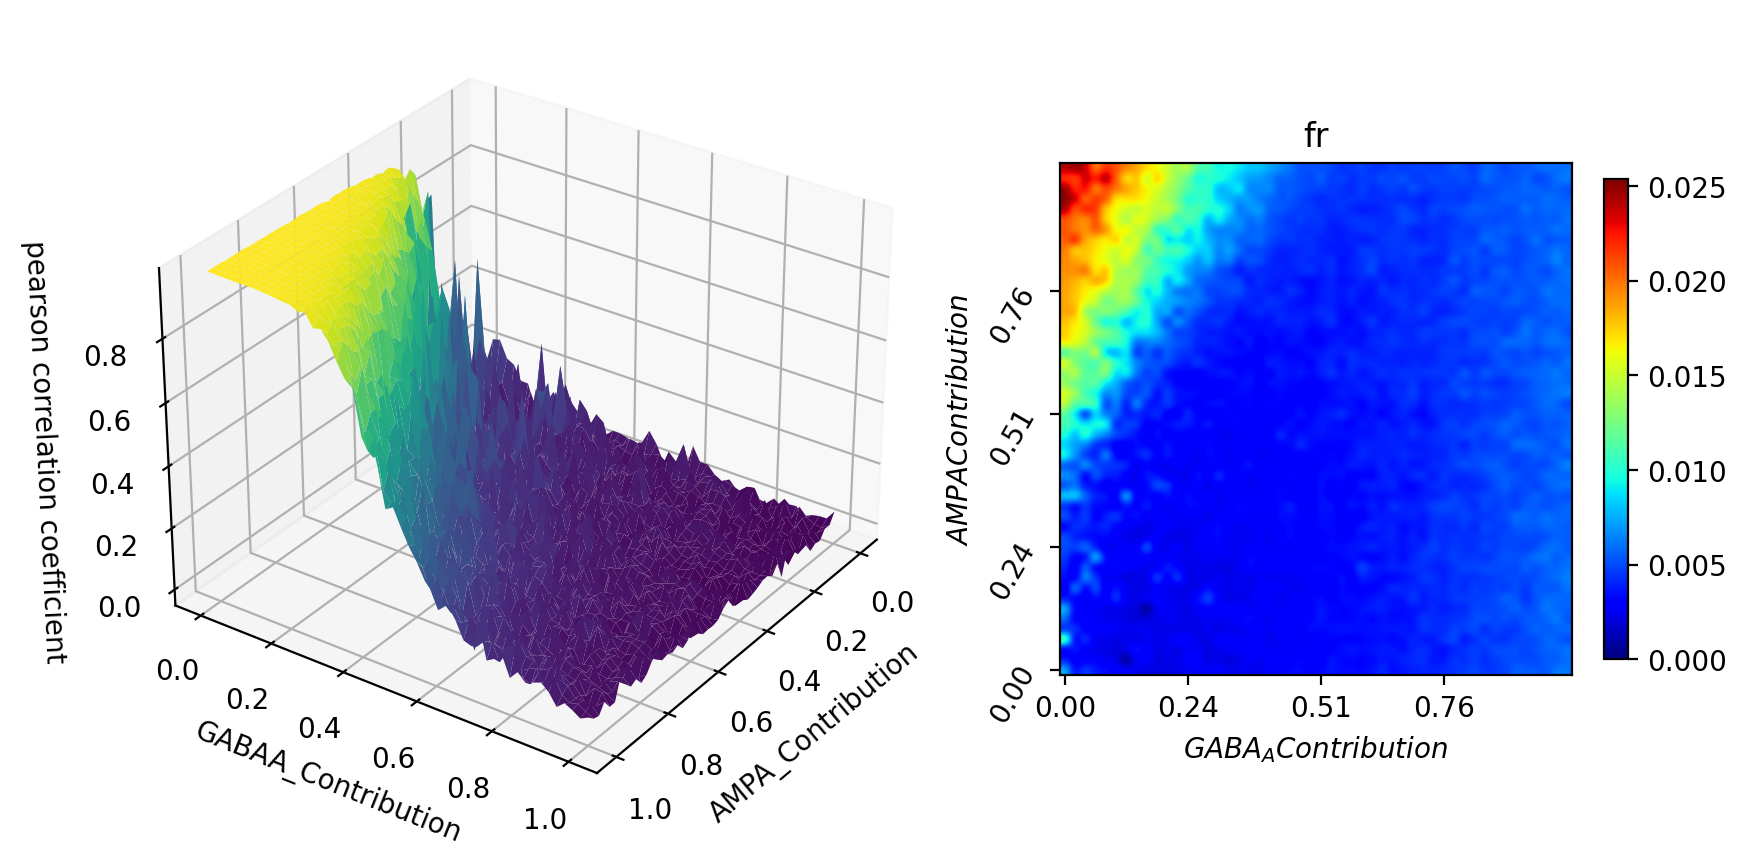

In [7]:
pcc = np.load('../data/grid_search_d300_specific_range_0to1.npz')["pcc"]
x = np.linspace(0., 1., 50)
y = np.linspace(0., 1., 50)
xx, yy = np.meshgrid(x, y, indexing="ij")
fig = plt.figure(figsize=(10, 5), dpi=200)
ax = fig.add_axes([0.08, 0.1, 0.5, 0.8], projection='3d')
ax.plot_surface(xx, yy, pcc, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel("AMPA_Contribution")
ax.set_ylabel("GABAA_Contribution")
ax.set_zlabel("pearson correlation coefficient")
ax.view_init(30, 35)

ax =  fig.add_axes([0.6, 0.1, 0.32, 0.8])
fr = np.load('../data/grid_search_d300_specific_range_0to1.npz')["mean_fr"]
m, n = fr.shape
im = fig.gca().imshow(fr, cmap='jet', interpolation='gaussian')
fig.colorbar(im, ax=fig.gca(), shrink=0.6)
fig.gca().grid(False)
yticks = np.linspace(0, m, 4, endpoint=False, dtype=np.int8)
fig.gca().set_yticks(yticks)
fig.gca().set_yticklabels([f'{data:.2f}' for data in x[yticks]], rotation=60)
xticks = np.linspace(0, n, 4, endpoint=False, dtype=np.int8)
fig.gca().invert_yaxis()
fig.gca().set_xticks(xticks)
fig.gca().set_xticklabels([f'{data:.2f}' for data in y[xticks]], )
fig.gca().set_ylabel(r"$AMPA Contribution$")
fig.gca().set_xlabel(r"$GABA_{A} Contribution$")
fig.gca().set_title("fr")
fig.savefig("../paper/fig/degree_300.png")

# degree 500, size 2000

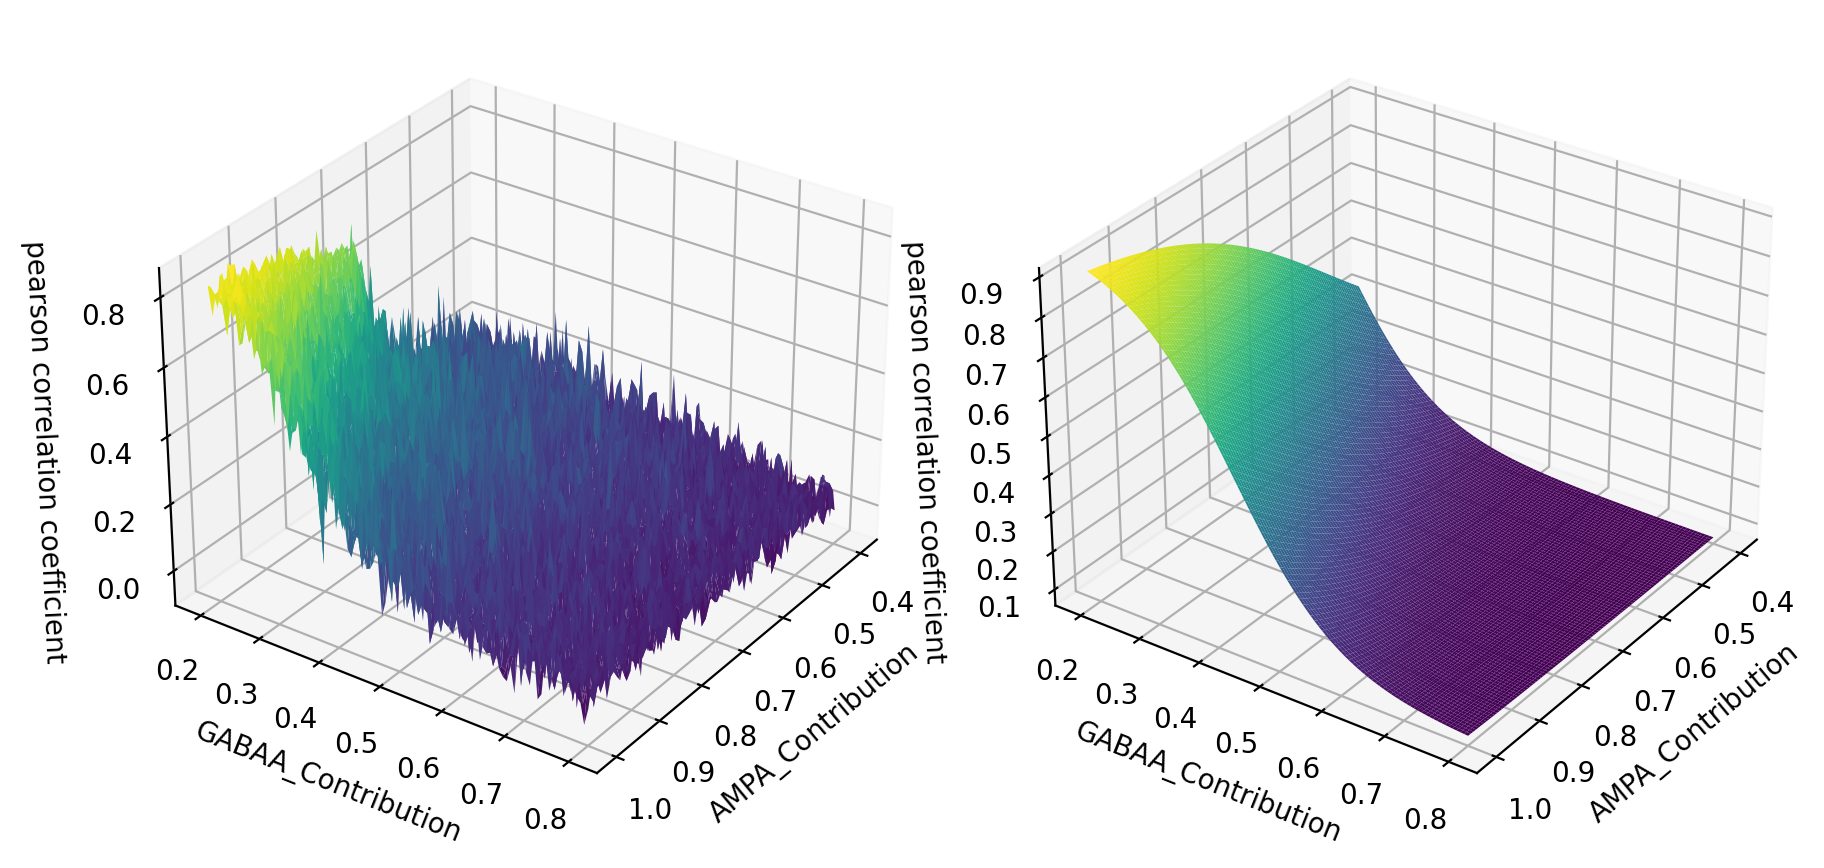

In [12]:
file2 = np.load('../data/grid_search_d500_specific_range.npz')
pcc = file2['pcc']
x = np.linspace(0.4, 1., 100)
y = np.linspace(0.2, 0.8, 100)
xx, yy = np.meshgrid(x, y, indexing="ij")
fig = plt.figure(figsize=(10, 5), dpi=200)
ax = fig.add_axes([0.08, 0.1, 0.4, 0.8], projection='3d')
ax.plot_surface(xx, yy, pcc, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel("AMPA_Contribution")
ax.set_ylabel("GABAA_Contribution")
ax.set_zlabel("pearson correlation coefficient")
ax.view_init(30, 35)

ax = fig.add_axes([0.52, 0.1, 0.4, 0.8], projection='3d')
file = loadmat(r"C:\Users\lucky\Documents\WeChat Files\wxid_yv8ys00jk82222\FileStorage\File\2022-05\results_grid_search_d500_specific_range_0.4_1.mat")
a_pcc = file["a_pcc"].squeeze()
b_pcc = file["b_pcc"].squeeze()
func_pcc = b_pcc[0] * np.tanh(a_pcc[0] * xx + a_pcc[1] * yy + a_pcc[2]) + b_pcc[1]
ax.plot_surface(xx, yy, func_pcc, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel("AMPA_Contribution")
ax.set_ylabel("GABAA_Contribution")
ax.set_zlabel("pearson correlation coefficient")
ax.view_init(30, 35)
fig.savefig("../paper/fig/degree_influence_3d.png")

# Conclusion of critical dynamic dependece on degree size

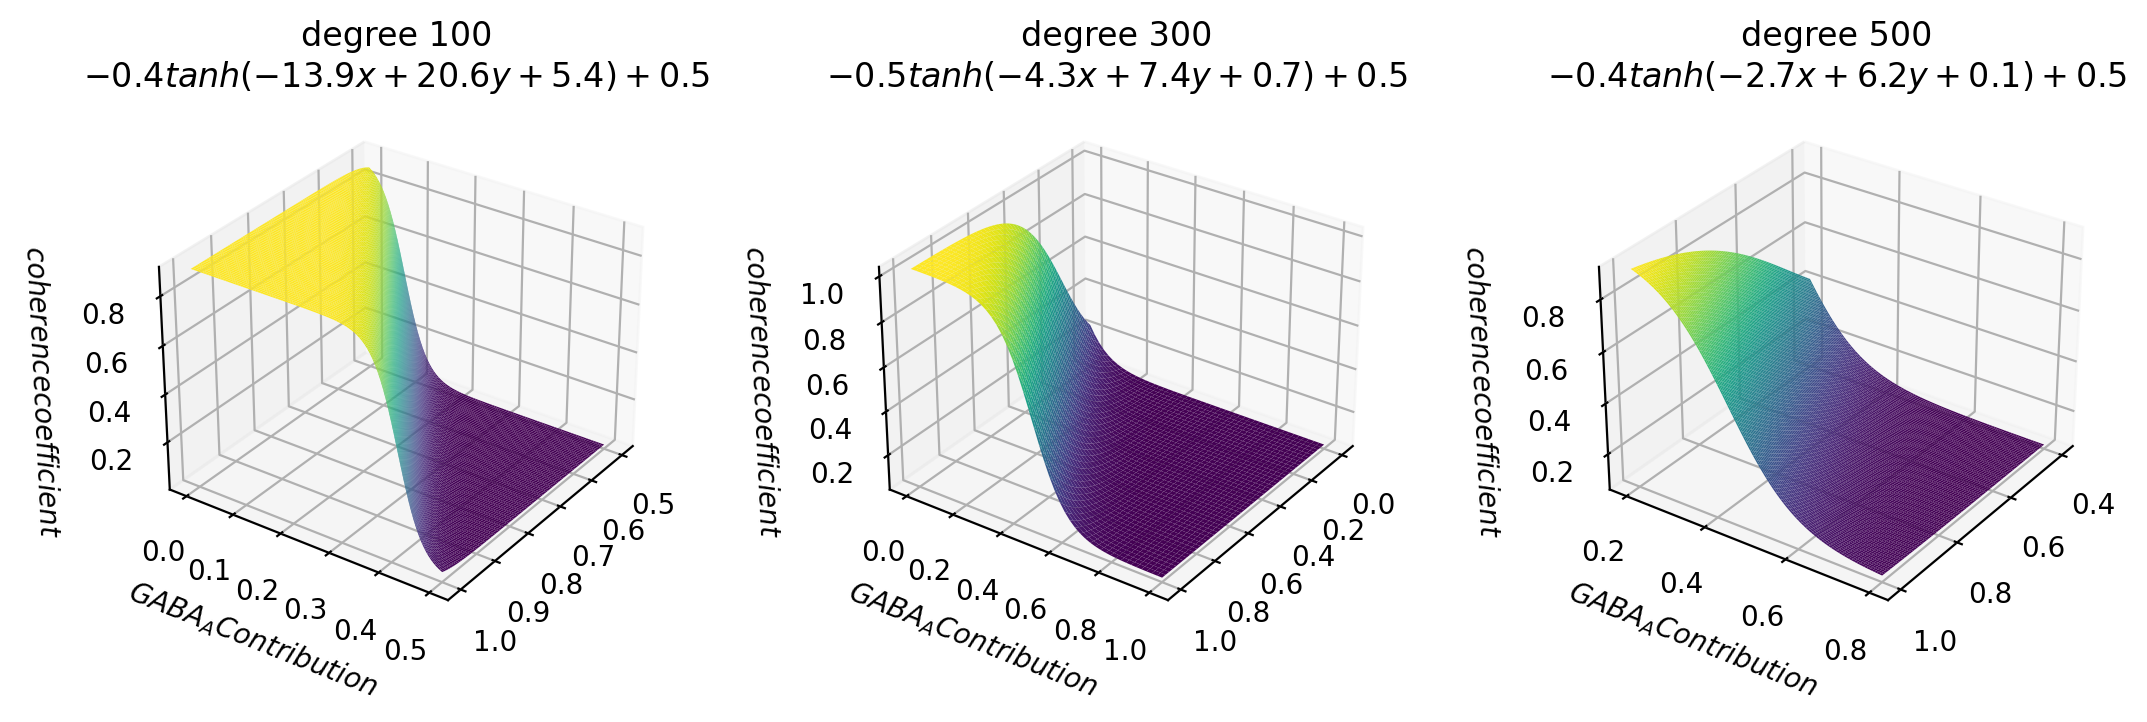

In [52]:
def surface(file_path, ax, degree):
    file = loadmat(file_path)
    x = file["ampa_contribution"]
    y = file["gabaA_contribution"]
    xx , yy = np.meshgrid(x, y, indexing="ij")
    a_pcc = file["a_pcc"].squeeze()
    b_pcc = file["b_pcc"].squeeze()
    func_pcc = b_pcc[0] * np.tanh(a_pcc[0] * xx + a_pcc[1] * yy + a_pcc[2]) + b_pcc[1]
    ax.plot_surface(xx, yy, func_pcc, rstride=1, cstride=1,
                    cmap='viridis', edgecolor='none')
    ax.set_ylabel(r"$GABA_{A} Contribution$")
    ax.set_zlabel(r"$coherence coefficient$")
    s = "degree {}\n${:.1f}tanh({:.1f}x+{:.1f}y+{:.1f})+{:.1f}$".format(degree, b_pcc[0],a_pcc[0], a_pcc[1], a_pcc[2], b_pcc[1])
    ax.set_title(s, fontsize=12)
    ax.view_init(30, 35)

fig = plt.figure(figsize=(12, 5), dpi=200)
degree = [100, 300, 500]
pannel_gap = 0.08
pannel_width = 0.22
pannel_width_start = (1 - 3 * (pannel_gap + pannel_width)) / 2
for i, idx in enumerate(degree):
    file_dir = "../data/degree_influence/grid_search_d" + f"{idx}.mat"
    ax = fig.add_axes([pannel_width_start + i * (pannel_width + pannel_gap), 0.1, pannel_width, 0.8 ], projection="3d")
    surface(file_dir, ax, idx)

fig.savefig("../paper/fig/fit_surface.png")

# ks distance corresponding to pcc

Text(0, 0.5, 'ks')

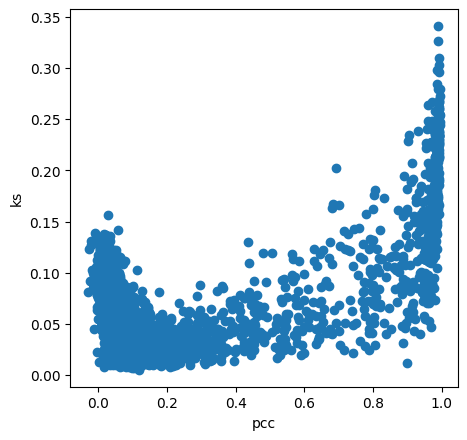

In [3]:
file = np.load('../data/grid_search_d300_specific_range_0to1.npz')
pcc = file['pcc']
ks = file["ks"]
fig = plt.figure(figsize=(5, 5), dpi=100)
fig.gca().scatter(pcc.flatten(), ks.flatten())
fig.gca().set_xlabel("pcc")
fig.gca().set_ylabel("ks")